![](https://zmiclab.github.io/zxh/0/mmwhs/res/MMData2.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-segmentation-decathlon-heart/dataset.json
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_001.nii/la_001.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_012.nii/la_012.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_006.nii/la_006.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_008.nii/la_008.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_002.nii/la_002.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_025.nii/la_025.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_013.nii/la_013.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_028.nii/la_028.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_027.nii/la_027.nii
/kaggle/input/medical-segmentation-decathlon-heart/imagesTs/la_015.nii/la_015.nii
/kaggle/input/medical-segmentation-decathlon-heart/labelsTr/la_017.nii/la_017.nii
/kaggle/input/medical-segmentation

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.1 MB/s eta 0:00:00


In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImage,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    DivisiblePadd,
    RandAffined,
    RandRotated,
    RandGaussianNoised
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

In [4]:
import torch
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from datetime import datetime

In [5]:
data_dir = "/kaggle/input/medical-segmentation-decathlon-heart"
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*/*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*/*.nii")))

In [6]:
train_images[0]

'/kaggle/input/medical-segmentation-decathlon-heart/imagesTr/la_003.nii/la_003.nii'

In [7]:
train_labels[0]

'/kaggle/input/medical-segmentation-decathlon-heart/labelsTr/la_003.nii/la_003.nii'

In [8]:
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-4], data_dicts[-4:] # 16 train and 4 validation
train_files

[{'image': '/kaggle/input/medical-segmentation-decathlon-heart/imagesTr/la_003.nii/la_003.nii',
  'label': '/kaggle/input/medical-segmentation-decathlon-heart/labelsTr/la_003.nii/la_003.nii'},
 {'image': '/kaggle/input/medical-segmentation-decathlon-heart/imagesTr/la_004.nii/la_004.nii',
  'label': '/kaggle/input/medical-segmentation-decathlon-heart/labelsTr/la_004.nii/la_004.nii'},
 {'image': '/kaggle/input/medical-segmentation-decathlon-heart/imagesTr/la_005.nii/la_005.nii',
  'label': '/kaggle/input/medical-segmentation-decathlon-heart/labelsTr/la_005.nii/la_005.nii'},
 {'image': '/kaggle/input/medical-segmentation-decathlon-heart/imagesTr/la_007.nii/la_007.nii',
  'label': '/kaggle/input/medical-segmentation-decathlon-heart/labelsTr/la_007.nii/la_007.nii'},
 {'image': '/kaggle/input/medical-segmentation-decathlon-heart/imagesTr/la_009.nii/la_009.nii',
  'label': '/kaggle/input/medical-segmentation-decathlon-heart/labelsTr/la_009.nii/la_009.nii'},
 {'image': '/kaggle/input/medical-s

In [9]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),        
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16)
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16)
    ]
)

augm_transforms = Compose(
    [
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.5),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` was changed in version 1.5 from `allow_smaller=True` to `allow_smaller=False`.
  warn_deprecated(argname, msg, warning_category)


In [10]:
# 16 images -> transform
train_ds = CacheDataset(data=train_files, transform=train_transforms)

# 16 images -> transform + data augmentation
augm_ds= CacheDataset(data=train_files, transform=[train_transforms, augm_transforms])

# Not declararing the batch size -> whole dataset -> 16(data) + 16(data augmentation) = 32 images per epoch
# this means 1 batch = 32 images
train_ds = ConcatDataset([train_ds, augm_ds])

train_loader = DataLoader(train_ds)

val_ds = CacheDataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds)

Loading dataset: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


In [11]:
# using CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# implementing the early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [13]:
model = UNet(
    spatial_dims=3,
    in_channels=1, # hard labeling
    out_channels=2, # soft labeling
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout =0.2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax = True)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, amsgrad = True)
early_stopper = EarlyStopper(patience=3, min_delta=0.3)

In [14]:
total_time = 0
max_epochs = 100
val_interval = 1 #not a large dataset, so it is fine
print_interval = 20
epoch_loss_values = []
losses_validation = []

for epoch in range(max_epochs):
    start_time = datetime.now()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train() # tell Dropout and BatchNorm to work bcs it is training
    epoch_loss = 0
    step = 0
    
    # getting data for each batch
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        
        # normal pipeline
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #loss.item -> each batch loss
        epoch_loss += loss.item()
        if (epoch) % print_interval == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    
    # measuring time        
    actual_time = datetime.now() - start_time
    print(f"time to train this epoch: {actual_time}")
    total_time += actual_time.total_seconds()
    # saving the loss for the actual epoch
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    

    if (epoch + 1) % val_interval == 0:
        model.eval() # tell Dropout and BatchNorm to "turn off" bcs I am evaluating the model
        with torch.no_grad():
            loss_val = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                #get the loss to the validation set
                outputs = model(val_inputs)
                loss_val = loss_function(outputs, val_labels).item()
            
            loss_val_avg = loss_val / val_loader.batch_size
            losses_validation.append(loss_val_avg)
            print(f"validation average loss: {loss_val_avg:.4f}")
            if early_stopper.early_stop(loss_val_avg):
                print("early stopped!")
                break

----------
epoch 1/100
1/32, train_loss: 1.4216
2/32, train_loss: 1.4158
3/32, train_loss: 1.4176
4/32, train_loss: 1.4129
5/32, train_loss: 1.4087
6/32, train_loss: 1.4087
7/32, train_loss: 1.4077
8/32, train_loss: 1.4017
9/32, train_loss: 1.4035
10/32, train_loss: 1.3947
11/32, train_loss: 1.3956
12/32, train_loss: 1.3930
13/32, train_loss: 1.3880
14/32, train_loss: 1.3860
15/32, train_loss: 1.3811
16/32, train_loss: 1.3773
17/32, train_loss: 1.3760
18/32, train_loss: 1.3741
19/32, train_loss: 1.3731
20/32, train_loss: 1.3638
21/32, train_loss: 1.3645
22/32, train_loss: 1.3626
23/32, train_loss: 1.3596
24/32, train_loss: 1.3539
25/32, train_loss: 1.3530
26/32, train_loss: 1.3467
27/32, train_loss: 1.3480
28/32, train_loss: 1.3569
29/32, train_loss: 1.3499
30/32, train_loss: 1.3498
31/32, train_loss: 1.3457
32/32, train_loss: 1.3436
time to train this epoch: 0:00:37.039867
epoch 1 average loss: 1.3792
validation average loss: 1.2883
----------
epoch 2/100
time to train this epoch: 0:0

In [15]:
torch.save(model, "/kaggle/working/unet3dAdamwDicece.h5")

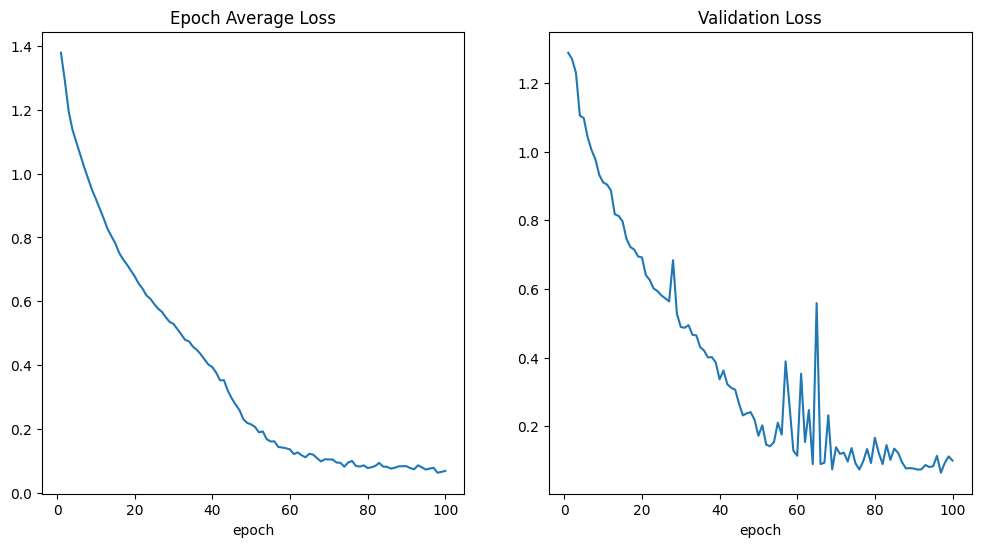

In [16]:
%matplotlib inline
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation Loss")
x = [val_interval * (i + 1) for i in range(len(losses_validation))]
y = losses_validation
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [17]:
images = []
outputs = []
labels = []
for val_data in val_loader: 
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
        #val_data["image"].cpu(),
        #val_data["label"].cpu(),
    )
    images.append(val_inputs)
    outputs.append(model(val_inputs))
    labels.append(val_labels)

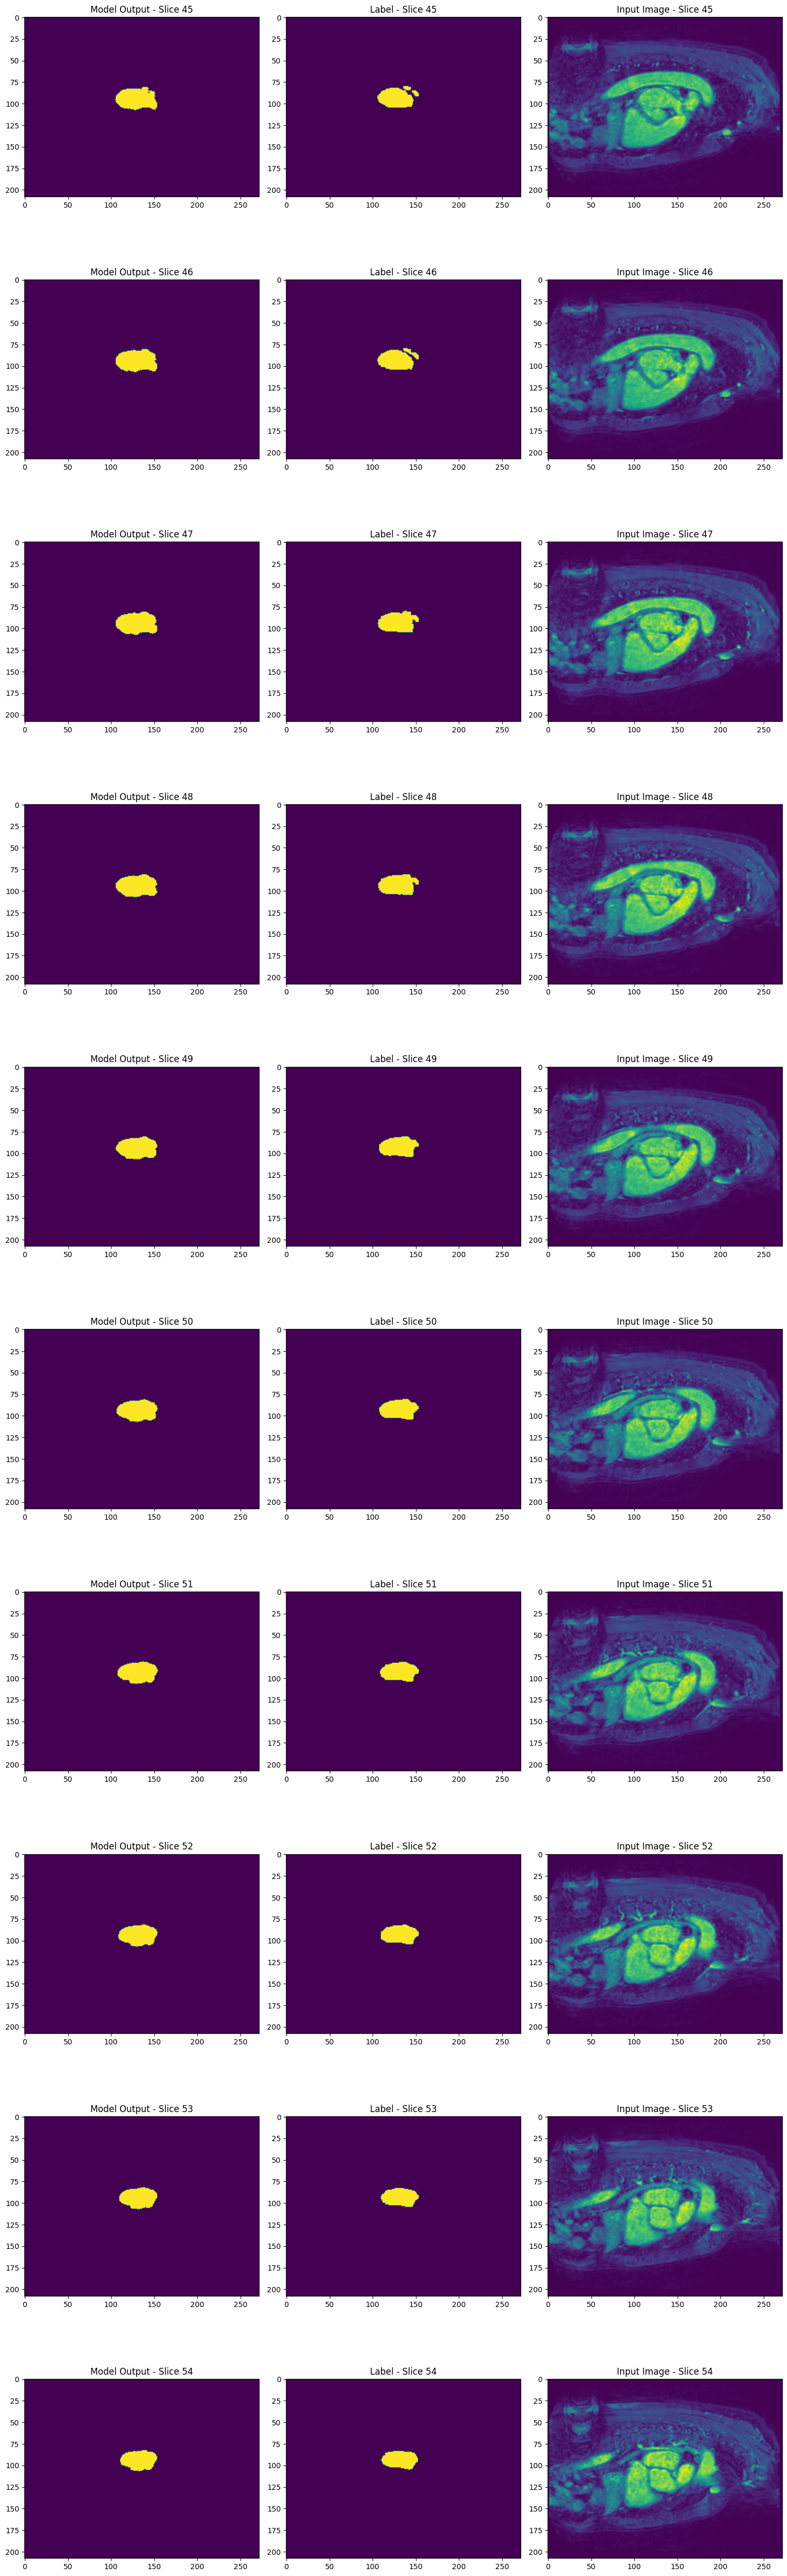

In [18]:
# Assuming outputs, labels, and images are your variables
output = outputs[0]
label = labels[0][0][0]
image = images[0][0][0]

# Set the slice range from 45 to 50
slice_start = 45
slice_end = 55

# Calculate the number of slices
num_slices = slice_end - slice_start

# Create a subplot with 'num_slices' rows and 3 columns
plt.figure(figsize=(15, 5 * num_slices))

for i in range(num_slices):
    # Increment the slice index
    current_slice = slice_start + i
    
    # Plot the Model Output
    plt.subplot(num_slices, 3, 3 * i + 1)
    with torch.no_grad():
        plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
    plt.title(f'Model Output - Slice {current_slice}')

    # Plot the Label
    plt.subplot(num_slices, 3, 3 * i + 2)
    plt.imshow(label.cpu()[:, :, current_slice])
    plt.title(f'Label - Slice {current_slice}')

    # Plot the Input Image
    plt.subplot(num_slices, 3, 3 * i + 3)
    plt.imshow(image.cpu()[:, :, current_slice])
    plt.title(f'Input Image - Slice {current_slice}')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()